In [152]:
import os
import nltk

import marisa_trie

with open('../data/processed/word_freqs/freq_1000000_oshhamaho.txt') as f:
    words = f.read().split('\n')

word_index_map = {word: id for id, word in enumerate(sorted(words))}

word2word_id_trie = marisa_trie.RecordTrie(
    "I", [(word, (word_id,)) for word, word_id in word_index_map.items()]
)

os.makedirs('../data/processed/spell_checker', exist_ok=True)
word2word_id_trie.save('../data/processed/spell_checker/word2word_id_trie.marisa')

In [153]:
def word_exists(word, trie):
    return word in trie


print(word_exists('пщэдджыжь', word2word_id_trie))
print(word_exists('пщэджыжь', word2word_id_trie))

True
False


In [156]:
import pandas as pd

df_stem_templates = pd.read_csv('../data/processed/token_distribution/stem_templates.csv')

df_stem_templates['prefix'] = df_stem_templates['template'].apply(
    lambda x: x.split('*')[0] if len(x.split('*')) == 2 else ''
)

df_stem_templates['suffix'] = df_stem_templates['template'].apply(
    lambda x: x.split('*')[1] if len(x.split('*')) == 2 else ''
)

prefix_cfd = nltk.ConditionalFreqDist()
suffix_cfd = nltk.ConditionalFreqDist()

for prefix, suffix in df_stem_templates[['prefix', 'suffix']].values:
    prefix_cfd[len(prefix)][prefix] += 1
    suffix_cfd[len(suffix)][suffix] += 1


def prefix_freq(word, prefix_cfd, n=3):
    prefix = word[:n]
    return prefix_cfd.get(n, {}).get(prefix, 0)

def suffix_freq(word, suffix_cfd, n=3):
    suffix = word[-n:]
    return suffix_cfd.get(n, {}).get(suffix, 0)

In [157]:
print(prefix_cfd[1].most_common(10))

print(prefix_freq('сызэ', prefix_cfd, n=4))
print(suffix_freq('къым', suffix_cfd, n=4))

149

In [158]:
prefixes = set(df_stem_templates['prefix'].to_list())
suffixes = set(df_stem_templates['suffix'].to_list())

In [159]:
prefixes = sorted([prefix for prefix in prefixes if prefix != ''])
suffixes = sorted([suffix for suffix in suffixes if suffix != ''])

prefix_trie = marisa_trie.Trie(prefixes)
suffix_trie = marisa_trie.Trie(suffixes)

In [160]:
def prefix_exists(prefix, prefix_trie):
    return prefix in prefix_trie


def suffix_exists(suffix, suffix_trie):
    return suffix in suffix_trie


print(prefix_exists('къыздэ', prefix_trie))
print(prefix_exists('къысдэ', prefix_trie))

print(suffix_exists('еин', suffix_trie))
print(suffix_exists('син', suffix_trie))

True
False
True
False


In [161]:
from tokenizers import Tokenizer

tokenizer_uni = Tokenizer.from_file('../data/processed/tokenizer/words_unigram_5000.tokenizer.json')
tokenizer_bpe = Tokenizer.from_file('../data/processed/tokenizer/bpe_5000.tokenizer.json')


def char_len_tokens(word, tokenizer):
    toke_len_hash = ''.join([
        str(len(token))
        for token in tokenizer.encode(word).tokens
    ])
    return toke_len_hash


def has_one_char_token_consecutively(word, tokenizer):
    return '11' in char_len_tokens(word, tokenizer)


def has_many_one_char_tokens(word, tokenizer, n=1):
    return char_len_tokens(word, tokenizer).count('1') >= n


def token_ids(word, tokenizer):
    return tokenizer.encode(word).ids



In [162]:
word = 'пщэдджыжь'

print(token_ids(word, tokenizer_uni))
print(token_ids(word, tokenizer_bpe))
print(char_len_tokens(word, tokenizer_uni))
print(char_len_tokens(word, tokenizer_bpe))

[278, 46, 451, 125]
[1824, 127]
3132
72


In [163]:
from tqdm import tqdm

bigram_fd = nltk.FreqDist()
trigram_fd = nltk.FreqDist()

for word in tqdm(words):
    bigram_fd.update([''.join(bigram) for bigram in nltk.ngrams(word, 2)])
    trigram_fd.update([''.join(trigram) for trigram in nltk.ngrams(word, 3)])


def ngram_freq_treshold(trigram, treshold):
    return trigram_fd.get(trigram, 0) <= treshold


def treshold_ngram(word, treshold, n=3):
    return sum([
        int(ngram_freq_treshold(''.join(trigram), treshold))
        for trigram in nltk.ngrams(word, n)
    ])

100%|██████████| 483338/483338 [00:03<00:00, 123915.99it/s]


In [218]:
df_oshhamaho_freqs = pd.read_csv('../data/processed/word_freqs/freq_1000000_oshhamaho.csv', sep=',')
df_elgkbr_freqs = pd.read_csv('../data/processed/word_freqs/freq_1000000_elgkbr_ru.csv', sep=',')
df_apkbr_freqs = pd.read_csv('../data/processed/word_freqs/freq_1000000_apkbr_ru.csv', sep=',')

# df to count word frequency
oshhamaho_counter = df_oshhamaho_freqs.set_index('word')['freq'].to_dict()
elgkbr_counter = df_elgkbr_freqs.set_index('word')['freq'].to_dict()
apkbr_counter = df_apkbr_freqs.set_index('word')['freq'].to_dict()

def word_freq(word, counter):
    return counter.get(word, 0)

In [219]:
exist_df = pd.read_csv('../data/processed/word_freqs/freq_1000000_oshhamaho.txt', header=None, sep=' ')
exist_df.columns = ['word']
exist_df['target'] = 1
spelling_errors = pd.read_csv('../data/processed/spell_checker/synthetic_spelling_errors.txt', header=None, sep=' ')
spelling_errors.columns = ['word']
spelling_errors['target'] = 0

exist_df['word'] = exist_df['word'].astype(str)
spelling_errors['word'] = spelling_errors['word'].astype(str)

df = pd.concat([exist_df, spelling_errors])

In [230]:
import numpy as np


def fill_predictors(df):
    df['word_len'] = df['word'].apply(lambda x: len(x))

    df['token_len_uni'] = df['word'].apply(lambda x: len(tokenizer_uni.encode(x).tokens))
    df['token_len_bpe'] = df['word'].apply(lambda x: len(tokenizer_bpe.encode(x).tokens))

    df['word_line/char_len_uni'] = df['word_len'] / df['token_len_uni']
    df['word_line/char_len_bpe'] = df['word_len'] / df['token_len_bpe']

    df['2gram_treshold_10'] = df['word'].apply(lambda x: treshold_ngram(x, 10, n=2))
    df['2gram_treshold_100'] = df['word'].apply(lambda x: treshold_ngram(x, 100, n=2))

    df['3gram_treshold_10'] = df['word'].apply(lambda x: treshold_ngram(x, 10, n=3))
    df['3gram_treshold_100'] = df['word'].apply(lambda x: treshold_ngram(x, 100, n=3))
    df['3gram_treshold_500'] = df['word'].apply(lambda x: treshold_ngram(x, 500, n=3))
    df['3gram_treshold_1000'] = df['word'].apply(lambda x: treshold_ngram(x, 1000, n=3))

    df['4prefix_freq'] = df['word'].apply(lambda x: prefix_freq(x, prefix_cfd, n=4))
    df['3prefix_freq'] = df['word'].apply(lambda x: prefix_freq(x, prefix_cfd, n=3))
    df['2prefix_freq'] = df['word'].apply(lambda x: prefix_freq(x, prefix_cfd, n=2))
    df['1prefix_freq'] = df['word'].apply(lambda x: prefix_freq(x, prefix_cfd, n=1))

    df['4suffix_freq'] = df['word'].apply(lambda x: suffix_freq(x, suffix_cfd, n=4))
    df['3suffix_freq'] = df['word'].apply(lambda x: suffix_freq(x, suffix_cfd, n=3))
    df['2suffix_freq'] = df['word'].apply(lambda x: suffix_freq(x, suffix_cfd, n=2))
    df['1suffix_freq'] = df['word'].apply(lambda x: suffix_freq(x, suffix_cfd, n=1))

    df = df[df['token_len_bpe'] > 0]
    df = df[df['token_len_uni'] > 0]

    df['one_char_token_consecutively_uni'] = df['word'].apply(lambda x: has_one_char_token_consecutively(x, tokenizer_uni))
    df['one_char_token_consecutively_bpe'] = df['word'].apply(lambda x: has_one_char_token_consecutively(x, tokenizer_bpe))

    df['many_one_char_tokens_uni'] = df['word'].apply(lambda x: has_many_one_char_tokens(x, tokenizer_uni))
    df['many_one_char_tokens_bpe'] = df['word'].apply(lambda x: has_many_one_char_tokens(x, tokenizer_bpe))

    df['prefix_uni'] = df['word'].apply(lambda x: tokenizer_uni.encode(x).tokens[0])
    df['prefix_len_uni'] = df['prefix_uni'].apply(lambda x: len(x))
    df['prefix_id_uni'] = df['prefix_uni'].apply(lambda x: tokenizer_uni.token_to_id(x))

    df['prefix_bpe'] = df['word'].apply(lambda x: tokenizer_bpe.encode(x).tokens[0])
    df['prefix_len_bpe'] = df['prefix_bpe'].apply(lambda x: len(x))
    df['prefix_id_bpe'] = df['prefix_bpe'].apply(lambda x: tokenizer_bpe.token_to_id(x))

    df['suffix_uni'] = df['word'].apply(lambda x: tokenizer_uni.encode(x).tokens[-1])
    df['suffix_len_uni'] = df['suffix_uni'].apply(lambda x: len(x))
    df['suffix_id_uni'] = df['suffix_uni'].apply(lambda x: tokenizer_uni.token_to_id(x))

    df['suffix_bpe'] = df['word'].apply(lambda x: tokenizer_bpe.encode(x).tokens[-1])
    df['suffix_len_bpe'] = df['suffix_bpe'].apply(lambda x: len(x))
    df['suffix_id_bpe'] = df['suffix_bpe'].apply(lambda x: tokenizer_bpe.token_to_id(x))

    return df

df = fill_predictors(df)

In [231]:
df.head(n=100)

,word,target,word_len,word_freq_oshhamaho,word_freq_elgkbr,word_freq_apkbr,token_len_uni,token_len_bpe,word_line/char_len_uni,word_line/char_len_bpe,...,prefix_id_uni,prefix_bpe,prefix_len_bpe,prefix_id_bpe,suffix_uni,suffix_len_uni,suffix_id_uni,suffix_bpe,suffix_len_bpe,suffix_id_bpe
0,",",1,1,428272,180340,417242,1,1,1.000000,1.000000,...,4991,",",1,9,",",1,4991,",",1,9
1,.,1,1,297212,137571,323922,1,1,1.000000,1.000000,...,161,.,1,11,.,1,161,.,1,11
2,и,1,1,133661,100305,214308,1,1,1.000000,1.000000,...,10,и,1,71,и,1,10,и,1,71
3,–,1,1,92993,2613,9004,1,1,1.000000,1.000000,...,399,–,1,96,–,1,399,–,1,96
4,«,1,1,38086,27235,61171,1,1,1.000000,1.000000,...,4994,«,1,27,«,1,4994,«,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Зы,1,2,2358,488,1618,1,1,2.000000,2.000000,...,119,Зы,2,433,Зы,2,119,Зы,2,433
96,гуэрым,1,6,2349,539,1962,2,1,3.000000,6.000000,...,1052,гуэрым,6,706,ым,2,34,гуэрым,6,706
97,псэр,1,4,2341,394,1264,2,1,2.000000,4.000000,...,253,псэр,4,714,р,1,11,псэр,4,714
98,фIэщ,1,4,2312,563,1325,3,3,1.333333,1.333333,...,170,фI,2,225,щ,1,9,щ,1,88


In [232]:
from sklearn.model_selection import train_test_split

In [233]:
predictor_columns = [
    # 'word',
    # 'word_exists',
    'word_len',

    '2gram_treshold_10',
    '2gram_treshold_100',
    '3gram_treshold_10',
    '3gram_treshold_100',
    '3gram_treshold_500',
    '3gram_treshold_1000',

    '4prefix_freq',
    '3prefix_freq',
    '2prefix_freq',
    '1prefix_freq',

    '4suffix_freq',
    '3suffix_freq',
    '2suffix_freq',
    '1suffix_freq',

    'token_len_uni',
    'token_len_bpe',
    'word_line/char_len_uni',
    'word_line/char_len_bpe',
    'one_char_token_consecutively_uni',
    'one_char_token_consecutively_bpe',
    'many_one_char_tokens_uni',
    'many_one_char_tokens_bpe',
    # 'tokens_uni',
    # 'token_ids_uni',
    # 'tokens_bpe',
    # 'token_ids_bpe',
    # 'prefix_uni',
    'prefix_len_uni',
    'prefix_id_uni',
    # 'prefix_bpe',
    'prefix_len_bpe',
    'prefix_id_bpe',
    # 'suffix_uni',
    'suffix_len_uni',
    'suffix_id_uni',
    # 'suffix_bpe',
    'suffix_len_bpe',
    'suffix_id_bpe',
]

df.dropna(inplace=True)
x = df[predictor_columns]

y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [234]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=16, min_samples_split=2)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(max_depth=16, random_state=42)

In [225]:
from sklearn.metrics import accuracy_score

y_pred = rf_classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9928399964027035


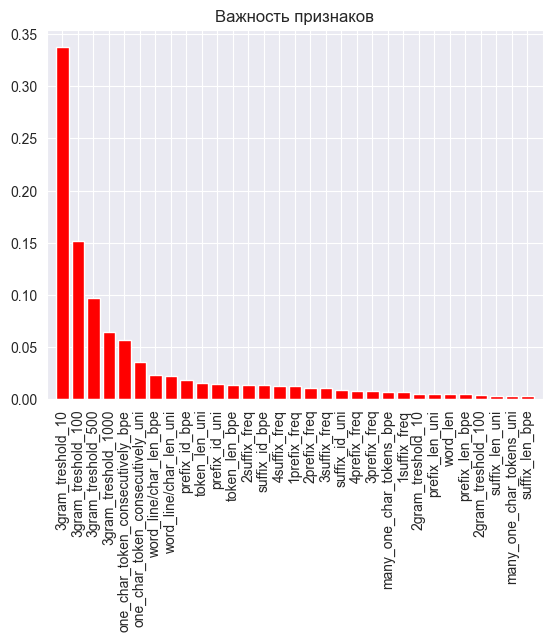

In [235]:
import matplotlib.pyplot as plt

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Важность признаков")
plt.bar(
    x=range(x_train.shape[1]),
    height=importances[indices],
    color="r",
    align="center"
)
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [149]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100],
    'max_depth': [16, 32],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=parameters, cv=5)
grid_search.fit(x_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая оценка: 0.8859203952475918


In [150]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(grid_search.best_estimator_, x, y, cv=5)

print("Средняя точность кросс-валидации:", cv_scores.mean())

Средняя точность кросс-валидации: 0.8813607494625298


In [151]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.17      0.29     22241
           1       0.89      1.00      0.94    145057

    accuracy                           0.89    167298
   macro avg       0.87      0.59      0.61    167298
weighted avg       0.88      0.89      0.85    167298


In [249]:
from src.logic.text_cleaner import clean_text

with open('../data/external/all_book.txt') as f:
    text = f.read()
    clean_text = clean_text(text)
    book_words = nltk.word_tokenize(text)
    book_words = sorted(set(book_words))

with open('../data/processed/word_freqs/freq_1000000_apkbr_ru.txt') as f:
    words = f.read().split('\n')

test_df = pd.DataFrame({
    'word': words,
})

test_df = fill_predictors(test_df)
test_df.dropna(inplace=True)

In [250]:
test_df

,word,word_len,token_len_uni,token_len_bpe,word_line/char_len_uni,word_line/char_len_bpe,2gram_treshold_10,2gram_treshold_100,3gram_treshold_10,3gram_treshold_100,...,prefix_id_uni,prefix_bpe,prefix_len_bpe,prefix_id_bpe,suffix_uni,suffix_len_uni,suffix_id_uni,suffix_bpe,suffix_len_bpe,suffix_id_bpe
0,",",1,1,1,1.000000,1.000000,0,0,0,0,...,4991,",",1,9,",",1,4991,",",1,9
1,.,1,1,1,1.000000,1.000000,0,0,0,0,...,161,.,1,11,.,1,161,.,1,11
2,и,1,1,1,1.000000,1.000000,0,0,0,0,...,10,и,1,71,и,1,10,и,1,71
3,я,1,1,1,1.000000,1.000000,0,0,0,0,...,24,я,1,94,я,1,24,я,1,94
4,«,1,1,1,1.000000,1.000000,0,0,0,0,...,4994,«,1,27,«,1,4994,«,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453528,сыщытыху,8,3,3,2.666667,2.666667,7,7,0,0,...,301,сы,2,148,ху,2,39,ху,2,112
453529,сакъыхэтIысхьэнущ,17,9,10,1.888889,1.700000,16,16,0,0,...,75,са,2,337,энущ,4,1333,нущ,3,671
453530,хуэарэзыхэм,11,3,3,3.666667,3.666667,10,10,0,0,...,51,хуэ,3,120,хэм,3,27,хэм,3,129
453531,сызыхунэмысар,13,4,4,3.250000,3.250000,12,12,0,0,...,496,сызы,4,1620,ар,2,57,сар,3,2663


In [251]:
calculated_df = rf_classifier.predict(test_df[predictor_columns])
test_df['calc'] = calculated_df

word_calc = test_df[['word', 'calc']]
# word_calc = word_calc[word_calc['calc'] == 0]
word_calc

,word,calc
0,",",1
1,.,1
2,и,0
3,я,1
4,«,1
...,...,...
453528,сыщытыху,1
453529,сакъыхэтIысхьэнущ,1
453530,хуэарэзыхэм,1
453531,сызыхунэмысар,1


In [252]:
import argilla as rg
from argilla import TextClassificationRecord

rg.init(api_url="http://localhost:6900", api_key="argilla.apikey")

records = []
for word, calc in tqdm(word_calc.values):
    records.append(
        TextClassificationRecord(
            text=word,
            prediction=[('valid' if calc == 1 else 'invalid', calc)],
            metadata={
                'source': 'freq_1000000_apkbr_ru',
                'freq': word_freq(word, elgkbr_counter),
                'tokens_uni': tokenizer_uni.encode(word).tokens,
                'tokens_bpe': tokenizer_bpe.encode(word).tokens,
            },
        )
    )

dataset_rg = rg.DatasetForTextClassification(records)
rg.log(dataset_rg, name="kbd_words")

/Users/panagoa/PycharmProjects/zbze_blog/venv/lib/python3.11/site-packages/argilla/client/client.py:157: UserWarning: Default user was detected and no workspace configuration was provided, so the default 'argilla' workspace will be used. If you want to setup another workspace, use the `rg.set_workspace` function or provide a different one on `rg.init`
  warnings.warn(
100%|██████████| 453533/453533 [00:29<00:00, 15244.83it/s]


Output()

453533 records logged to ]8;id=359423;http://localhost:6900/datasets/argilla/kbd_words\http://localhost:6900/datasets/argilla/kbd_words]8;;\

BulkResponse(dataset='kbd_words', processed=453533, failed=0)